In [54]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
import sympy as sp
import statistics

In [55]:
# Read data file and initial parameters
input_file = 'raw_data.csv'
df = pd.read_csv(input_file)
nrow, ncol = df.shape
indexes = df.columns[1:].to_list()

**Question 1 :** Calculating Inputs


**a)** Monthly and annual average return

In [56]:
mar = {} # Monthly Arithmetic Return (Method 1)
mar2 = {} # Monthly Arithmetic Return (Method 2)
aar = {} # Annual Arithmetic Return (Method 1)
aar2 = {} # Annual Arithmetic Return (Method 2)
for index in indexes:
    mar[index] = df[index].mean()
    aar[index] = 12.0 * mar[index] 
    aar2[index] = df[index].sum() / 10.0
    mar2[index] = aar2[index] / 12.0

**b)** Monthly and annual standard deviation of return

In [57]:
msd = {} # Monthly Standard Deviation (Method 1)
msd2 = {} # Monthly Standard Deviation (Method 2)
asd = {} # Annual Standard Deviation (Method 1)
asd2 = {} # Annual Standard Deviation (Method 2)
df2 = pd.DataFrame({'No.': range(1,11)})

for index in indexes:
    msd[index] = df[index].std()
    asd[index] = (12.0**0.5) * msd[index] 

    index_ar = [] # Yearly returns of the index (10 years)
    for i in range(10):
        start = i * 12 # Index of first month of Year i
        end = start + 12 # Index after last month of Year i
        index_ar.append(df[index].iloc[start:end].sum())
  
    df2[index] = pd.DataFrame({index: index_ar})
    asd2[index] = statistics.stdev(index_ar)
    msd2[index] = asd2[index] / (12.0**0.5)
print(df2)


   No.     Tbill   Russell   S&P 500     Bonds  MSCI EAFE
0    1  0.016623 -0.215680 -0.243516  0.093556  -0.149994
1    2  0.010383  0.391684  0.242213  0.047294   0.354134
2    3  0.011099  0.167736  0.088834  0.071703   0.179852
3    4  0.027751  0.042314  0.032383  0.094253   0.130466
4    5  0.045961  0.166387  0.129859  0.054166   0.235844
5    6  0.046891 -0.020552  0.039043  0.075608   0.099995
6    7  0.017538 -0.379986 -0.454537  0.219410  -0.479549
7    8  0.000933  0.266643  0.235816 -0.067258   0.280258
8    9  0.001137  0.254547  0.137983  0.061499   0.106051
9   10  0.000568 -0.031398  0.011463  0.251856  -0.111989


**c)** Correlation between indexes of risky asset classes

In [58]:
corr = df.corr(method='pearson') # Correlation matrix
corr = corr.drop(labels=indexes[0], axis=0) # Remove T-bill from x-axis
corr = corr.drop(labels=indexes[0], axis=1) # Remove T-bill from y-axis

In [59]:
corr2 = df2.corr(method='pearson') # Correlation matrix
corr2 = corr2.drop(labels=[indexes[0],'No.'], axis=0) # Remove T-bill from x-axis
corr2 = corr2.drop(labels=[indexes[0],'No.'], axis=1) # Remove T-bill from y-axis

**Question 2:** Optimal Asset Allocation

**a)** Plot efficient frontier and calculate minimum unconstrained portfolio standard deviation

In [60]:
cov = corr.copy() # Initialise covariance matrix
for i in indexes:
    for j in indexes:
        if (i == indexes[0] or j == indexes[0]): 
            continue # Skip T-bill (index 0)
        cov[i].loc[j] = corr[i].loc[j] * asd[i] * asd[j]

In [61]:
# y axis: [.0001, .0002, ..., .3999, .4000] = [.01%, .02%, ..., 39.99%, 40.00%]
y_axis_2a = [x / 1000 for x in range(401)] 

In [62]:
def get_portfolio_std(w): # Matrix formula of portfolio standard deviation
    return (np.matmul(np.matmul(w, cov), np.transpose(w)))**0.5

In [63]:
def constraint_weight(w): # Ensure sum of weight is 1
    return w.sum() - 1

In [64]:
target = 0 # Initialise target to be used later
def constraint_mean(w): # Ensure mean = target 
    w1, w2, w3, w4 = w
    mean = w1*aar[indexes[1]] + w2*aar[indexes[2]] + w3*aar[indexes[3]] + w4*aar[indexes[4]]
    return mean - target

In [65]:
# Initialise parameters required for solver
w0 = [.25, .25, .25, .25] 
constraints_2a = [ 
    {'type': 'eq', 'fun': constraint_weight},
    {'type': 'eq', 'fun': constraint_mean}
]

In [66]:
weights_2a = []
x_axis_2a = []
for i in range(len(y_axis_2a)):
    target = y_axis_2a[i] 
    solution = minimize(get_portfolio_std, x0=w0, constraints=constraints_2a).x
    x_axis_2a.append(get_portfolio_std(solution))
    weights_2a.append(solution)

Text(0, 0.5, 'Portfolio Return')

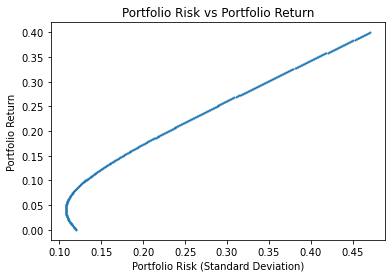

In [67]:
# Plot (Risk vs Return) scatter plot
plt.scatter(x_axis_2a, y_axis_2a, marker="o", s=1)
plt.title("Portfolio Risk vs Portfolio Return")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")

In [68]:
w0 = [.25, .25, .25, .25] 

In [72]:
#  Minimum unconstrained portfolio standard deviation
target = 0
weights_2a = minimize(get_portfolio_std, x0=w0, constraints=constraints_2a[:1]).x # GMV weights
min_std_2a = get_portfolio_std(weights_2a) # GMV std
aar_2a = constraint_mean(weights_2a) # GMV return = 4.14%
min_std_index_2a = min([i for i in range(401) if y_axis_2a[i] > aar_2a]) # Closest min index is 42

Text(0, 0.5, 'Portfolio Return')

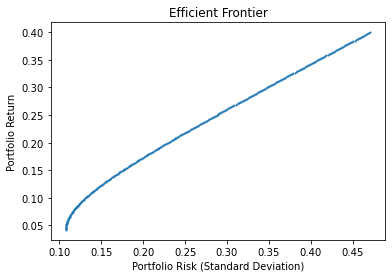

In [73]:
# Plot efficient frontier
plt.scatter(x_axis_2a[min_std_index_2a:], y_axis_2a[min_std_index_2a:], marker="o", s=1)
plt.title("Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")

In [74]:
rf = .018
def get_negative_sharpe_ratio(w):
    w1, w2, w3, w4 = w
    mean = w1*aar[indexes[1]] + w2*aar[indexes[2]] + w3*aar[indexes[3]] + w4*aar[indexes[4]]
    std = (np.matmul(np.matmul(w, cov), np.transpose(w)))**0.5
    return  -1 * (mean - .018) / std

In [75]:
constraints_2c = [
    {'type': 'eq', 'fun': constraint_weight} # Weights sum up to 1
]

In [76]:
# Compute point with maximum sharpe ratio
sol = minimize(get_negative_sharpe_ratio, x0=w0, constraints=constraints_2c)
max_sr_2c = -1 * sol.fun
y_max_sr_2c = constraint_mean(sol.x)
x_max_sr_2c = get_portfolio_std(sol.x)
w_max_sr_2c = sol.x

In [77]:
# Parameters to plot tangency line
rf = .018
x_axis_2c = [i/100.0 for i in range(0,48)] 
y_axis_2c = [((i/100.0) * max_sr_2c + rf) for i in range(0,48)]

Text(0, 0.5, 'Portfolio Return')

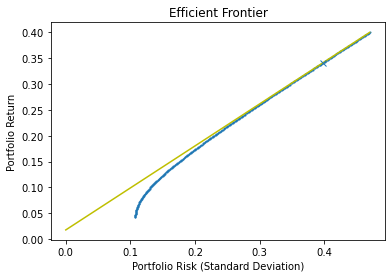

In [78]:
plt.figure()
plt.plot(x_axis_2c, y_axis_2c, '-y')
plt.scatter(x_axis_2a[min_std_index_2a:], y_axis_2a[min_std_index_2a:], marker="o", s=1)
plt.plot(x_max_sr_2c, y_max_sr_2c, marker="x")
plt.title("Efficient Frontier")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")

**Question 3:** Optimal Capital Allocation

In [79]:
# Dollar investment in each asset class
investor_A = [0.1] # Alex
investor_B = [0.5] # Roberto
investor_C = [0.9] # Cathy
for w in w_max_sr_2c:
    investor_A.append(w*.10)
    investor_B.append(w*.50)
    investor_C.append(w*.90)